In [1]:
from astropy.table import *
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import hstack
import os
import matplotlib
import matplotlib.backends.backend_pdf

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [2]:
path = '/Users/lejay/research/lephare_dev/filt/'
filter_files = ['CLAUDS/MegaCam/MegaCam_u.ascii',
                'CLAUDS/MegaCam/MegaCam_uS.ascii',
                'CLAUDS/HSC/hsc_g.dat',
                'CLAUDS/HSC/hsc_r.dat',
                'CLAUDS/HSC/hsc_i.dat',
                'CLAUDS/HSC/hsc_z.dat',
                'CLAUDS/HSC/hsc_y.dat',
                'IRAC/irac_1.pb',
                'IRAC/irac_2.pb',
                'CLAUDS/VISTA/Y_vista.pb',
                'CLAUDS/VISTA/J_vista.pb',
                'CLAUDS/VISTA/H_vista.pb',
                'CLAUDS/VISTA/K_vista.pb']


Text(0, 0.5, 'transmission')

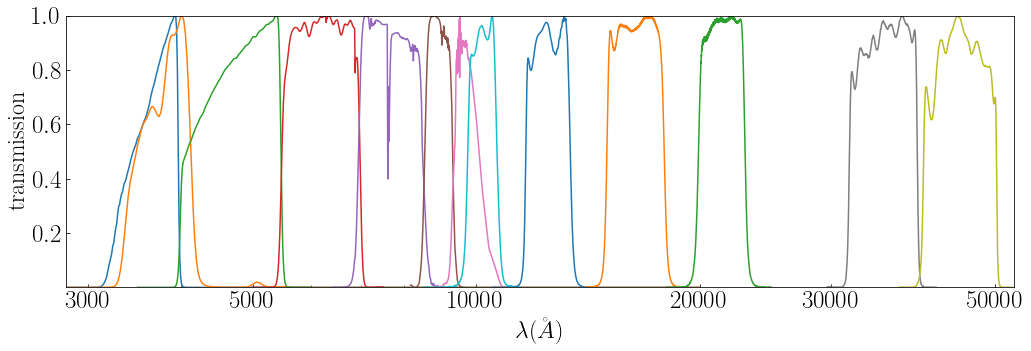

In [17]:
fig, axs = plt.subplots(1, 1, figsize = (17, 5),sharex=True, sharey=True)

for filt in filter_files:
    arr = np.loadtxt(path+filt)
    if 'VISTA' in filt:
        plt.plot(arr[:,0],arr[:,1]/max(arr[:,1]))
    else:
        plt.plot(arr[:,0],arr[:,1]/max(arr[:,1]))
    
plt.ylim([0.00001,1])
plt.xlim([2800,53000])
plt.xscale('log')
plt.xticks([3000,5000,10000,20000,30000,50000],['3000','5000','10000','20000','30000','50000'])
plt.xlabel('$\lambda (\AA)$',fontsize=24)
plt.ylabel('transmission',fontsize=24)


Text(0.5, 0, '$\\lambda (\\AA)$')

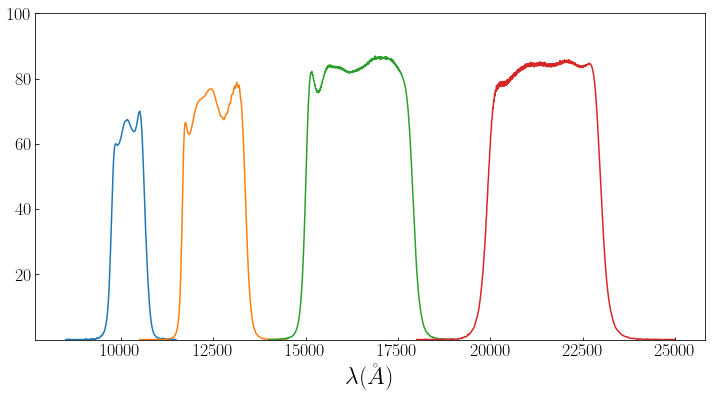

In [8]:
fig, axs = plt.subplots(1, 1, figsize = (12, 6),sharex=True, sharey=True)

for filt in filter_files:
    arr = np.loadtxt(path+filt)
    if 'VISTA' in filt:
        plt.plot(arr[:,0],arr[:,1])
    
plt.ylim([0.00001,100])
plt.xlabel('$\lambda (\AA)$',fontsize=24)
# plt.ylabel('transmission',fontsize=24)

#### survey geometry

In [5]:
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion

In [6]:
# megacam, hsc, vircam
cosmos_reg_filelist = ['MegaCam_u_cosmos.reg','MegaCam_uS_cosmos.reg','HSC_cosmos.reg','VIRCAM_J_cosmos.reg','IRAC_cosmos.reg']
xmm_reg_filelist = ['MegaCam_u_xmm.reg','MegaCam_uS_xmm_outline.reg','HSC_xmm.reg','VIRCAM_J_xmm.reg']
elais_reg_filelist = ['MegaCam_u_elais.reg','MegaCam_uS_elais.reg','HSC_elais.reg','VIRCAM_J_elais.reg','IRAC_elais.reg']
deep_reg_filelist = ['MegaCam_u_deep2.reg','MegaCam_uS_deep2.reg','HSC_deep2.reg','VIRCAM_J_deep2.reg','IRAC_deep2.reg']

# ra_min, ra_max, dec_min, dec_max
cosmos_radec_lim = [148,152,0.5,3.8]
xmm_radec_lim = [33,38.5,-7,-3]
elais_radec_lim = [239.5,246,53,57]
deep_radec_lim = [354,350,-2,1.5]

field_lim_list = [cosmos_radec_lim, xmm_radec_lim, elais_radec_lim, deep_radec_lim]
field_name_list = ['E-COSMOS','XMM-LSS','ELAIS-N1','DEEP2-3']
filter_list =['$u$','$u^*$','HSC','NIR','IRAC']

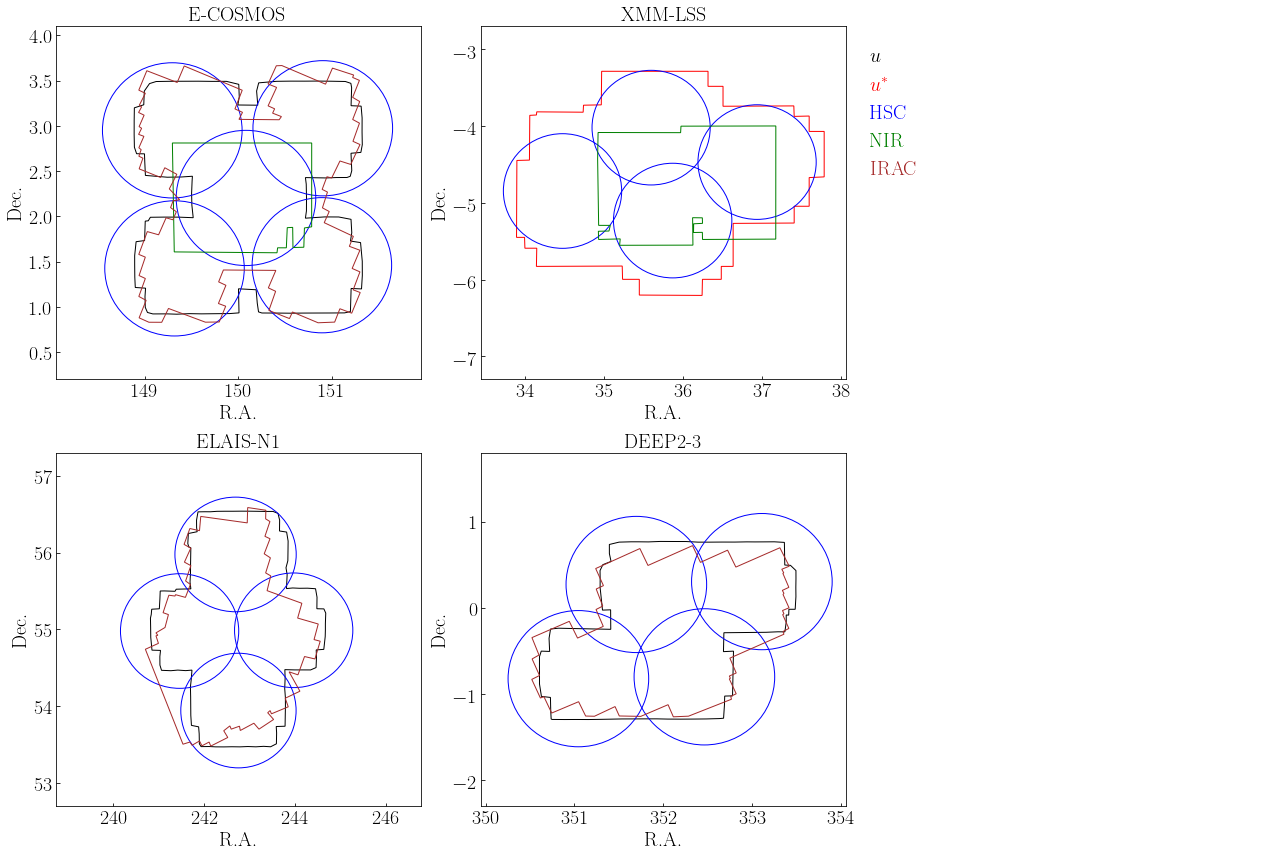

In [7]:
fig, axs = plt.subplots(2, 3, figsize = (18, 12))
colors = ['k','r','b','g','brown']
for field_num, field_reg_list in enumerate([cosmos_reg_filelist, xmm_reg_filelist, elais_reg_filelist,deep_reg_filelist]):
    row = field_num // 2
    col = field_num % 2
    for i,filename in enumerate(field_reg_list):
        file = open('../regions/'+filename)
        lines = file.readlines()
        
        if field_num==0 and i==1: #cosmos us
            continue
            
        for line in lines:
            if 'polygon' in line:
                line = 'wcs; fk5\n '+line.rstrip()
                region = DS9Parser(line).shapes.to_regions()[0]
                vertices = region.vertices
                pixel_vertex_x = []
                pixel_vertex_y = []
                for vertex in vertices:
                    pixel_vertex_x.append(vertex.ra.value)
                    pixel_vertex_y.append(vertex.dec.value)
                    pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
                artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)     
                
                axs[row][col].add_artist(artist)
            
            elif 'circle' in line:
                line = 'wcs; fk5\n '+line.rstrip()
                region = DS9Parser(line).shapes.to_regions()[0]
                x = region.center.ra.value
                y = region.center.dec.value
                pixel_center = PixCoord(x=x, y=y)
                pixel_ra_axis = region.radius.value/np.cos(region.center.dec.value/180*np.pi)/3600
                pixel_dec_axis = region.radius.value/3600
                pixel_region = EllipsePixelRegion(pixel_center, pixel_ra_axis*2,pixel_dec_axis*2)
            
                artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)        
                axs[row][col].add_artist(artist)
                
            elif 'box' in line:
                line = 'wcs; fk5\n '+line.rstrip()
                region = DS9Parser(line).shapes.to_regions()[0]
                x = region.center.ra.value
                y = region.center.dec.value
                pixel_center = PixCoord(x=x, y=y)
                pixel_height = region.height.value/3600
                pixel_width = region.width.value/3600
                pixel_region = RectanglePixelRegion(center=pixel_center, width=pixel_width,height=pixel_height)
            
                artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)        
                axs[row][col].add_artist(artist)
    
    ra_min = field_lim_list[field_num][0]-0.3
    ra_max = field_lim_list[field_num][1]+0.3
    ra_avg = (ra_min+ra_max)/2
    ra_diff = ra_max - ra_min
    
    dec_min = field_lim_list[field_num][2]-0.3
    dec_max = field_lim_list[field_num][3]+0.3
    dec_avg = (dec_min+dec_max)/2
    dec_diff = dec_max - dec_min
    
    aspect_ratio = ra_diff/dec_diff
    #np.cos(dec_avg/180.*np.pi)
    
    axs[row][col].set_xlim(ra_avg-ra_diff/np.cos(dec_avg/180.*np.pi)/aspect_ratio/2, ra_avg+ra_diff/np.cos(dec_avg/180.*np.pi)/aspect_ratio/2)
    axs[row][col].set_ylim(dec_min, dec_max)
    axs[row][col].set_xlabel('R.A.',fontsize=20)
    axs[row][col].set_ylabel('Dec.',fontsize=20)
    axs[row][col].set_adjustable(adjustable='box')
    axs[row][col].set_title(field_name_list[field_num],fontsize=20)
    # axs[row][col].set_aspect('equal')
    
plt.tight_layout()
axs[-1, -1].axis('off')
axs[0, 2].axis('off')

for i in range(len(colors)):
    axs[0][2].annotate(filter_list[i],xy=([-0.1,0.9-0.08*i]),xycoords='axes fraction',fontsize=20,color=colors[i])

#### find tract and patch from ra,dec

In [110]:
def find_patch(ra, dec, field='COSMOS_deep'):
    patch_list = []
    cat_patches = Table.read('tract_patches/'+field+'_patches.fits')
    for patch in cat_patches:
        if ra < patch['corner0'][0] and ra > patch['corner1'][0] and dec < patch['corner2'][1] and dec > patch['corner1'][1]:
            patch_list.append([str(patch['tract']), str(patch['patch'])])

    return patch_list


In [117]:
cat = Table.read('/Volumes/LejaySSD/COSMOS_deep_CLAUDS_v9_CH1_notmatched.fits')
for gal in cat:
    tract,patch = find_patch(gal['ALPHA_J2000_CH1'], gal['DELTA_J2000_CH1'], field='COSMOS_deep')[0]
    gal['TRACT']=tract
    gal['PATCH']=patch
    
cat.write('/Volumes/LejaySSD/COSMOS_deep_CLAUDS_v9_CH1_notmatched.fits',overwrite=True)

#### photometric error downgrade

In [119]:
cat_lp_central_cosmos = Table.read('../lephare_dev/my_code/graham_output_cats/cat_out_localrun_nonir_il_22.4_formass.fits')
cat_lp_overall_cosmos = Table.read('../lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_22.4_formass.fits')

In [174]:
cat_lp_central_cosmos = Table.read('../lephare_dev/my_code/input_cats/COSMOS_deep_base.fits')
cat_lp_overall_cosmos = Table.read('../lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_22.4_formass.fits')

In [175]:
step = 0.2
median_central = []
per16_central = []
per84_central = []
median_overall = []
per16_overall = []
per84_overall = []

for imag in np.arange(16,26,step):
    cat_lp_central_cosmos_z = cat_lp_central_cosmos[np.logical_and(cat_lp_central_cosmos['i']>imag,cat_lp_central_cosmos['i']<imag+step)]
    cat_lp_overall_cosmos_z = cat_lp_overall_cosmos[np.logical_and(cat_lp_overall_cosmos['i']>imag,cat_lp_overall_cosmos['i']<imag+step)]
    
    print(round(imag,2),round(imag+step,2),len(cat_lp_central_cosmos_z),len(cat_lp_overall_cosmos_z))        
    if len(cat_lp_central_cosmos_z)>0:
        median_central.append(np.median(cat_lp_central_cosmos_z['i_err']))
        per16_central.append(np.percentile(cat_lp_central_cosmos_z['i_err'],16))
        per84_central.append(np.percentile(cat_lp_central_cosmos_z['i_err'],84))
    else:
        median_central.append(0)
        per16_central.append(0)
        per84_central.append(0)
    
    if len(cat_lp_overall_cosmos_z)>0:
        median_overall.append(np.median(cat_lp_overall_cosmos_z['i_err']))
        per16_overall.append(np.percentile(cat_lp_overall_cosmos_z['i_err'],16))
        per84_overall.append(np.percentile(cat_lp_overall_cosmos_z['i_err'],84))
    else:
        median_overall.append(0)
        per16_overall.append(0)
        per84_overall.append(0)

median_central = np.array(median_central)
per16_central = np.array(per16_central)
per84_central = np.array(per84_central)
median_overall = np.array(median_overall)
per16_overall = np.array(per16_overall)
per84_overall = np.array(per84_overall)

16.0 16.2 0 3
16.2 16.4 0 6
16.4 16.6 0 7
16.6 16.8 1 18


/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


16.8 17.0 3 12
17.0 17.2 0 17
17.2 17.4 4 24
17.4 17.6 12 36
17.6 17.8 8 45
17.8 18.0 10 50
18.0 18.2 15 61
18.2 18.4 18 88
18.4 18.6 26 93
18.6 18.8 39 116
18.8 19.0 51 171
19.0 19.2 45 179
19.2 19.4 70 239
19.4 19.6 77 273
19.6 19.8 87 334
19.8 20.0 109 410
20.0 20.2 116 479
20.2 20.4 156 569
20.4 20.6 183 711
20.6 20.8 215 816
20.8 21.0 250 1034
21.0 21.2 316 1202
21.2 21.4 399 1408
21.4 21.6 457 1666
21.6 21.8 517 1930
21.8 22.0 648 2298
22.0 22.2 762 2901
22.2 22.4 910 3289
22.4 22.6 1030 3826
22.6 22.8 1201 4675
22.8 23.0 1428 5365
23.0 23.2 1690 6250
23.2 23.4 1957 7274
23.4 23.6 2286 8657
23.6 23.8 2666 10140
23.8 24.0 3064 11855
24.0 24.2 3520 13432
24.2 24.4 3984 15276
24.4 24.6 4434 17124
24.6 24.8 4956 18923
24.8 25.0 5503 21268
25.0 25.2 5886 23008
25.2 25.4 6472 25440
25.4 25.6 7033 27136
25.6 25.8 7463 29114
25.8 26.0 7707 30750


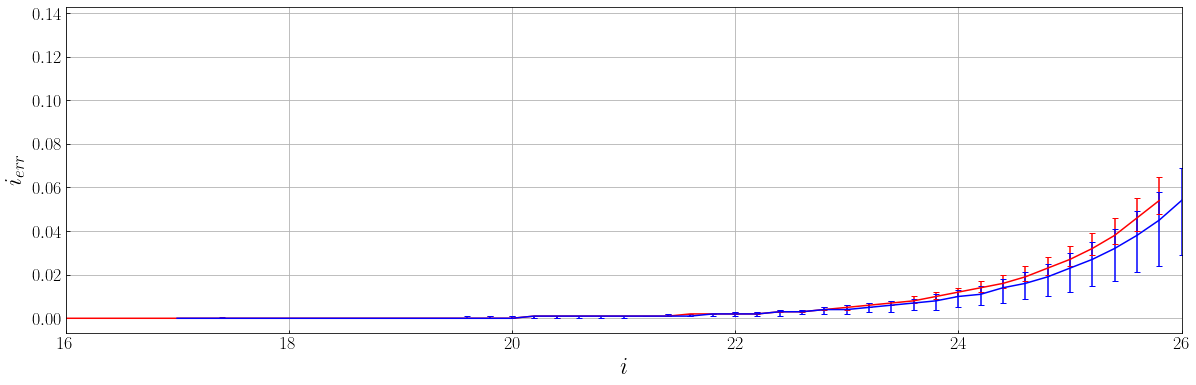

In [180]:
fig, ax = plt.subplots(figsize=(20, 6))

plt.errorbar(np.arange(16,26,step), median_central, yerr=[median_central-per16_central, per84_central-median_central],color='r',capsize=3)
plt.errorbar(np.arange(16,26,step)+1, median_overall, yerr=[median_overall-per16_overall, per84_overall-median_overall],color='b',capsize=3)

plt.xlim([16,26])
plt.xlabel('$i$',fontsize=24)
plt.ylabel('$i_{err}$',fontsize=24)
plt.grid()
